In [28]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [29]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [30]:
wiki.invoke("what is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [ ]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ['TAVILY_API_KEY']=os.getenv("TAVILY_API_KEY")
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
os.environ['LANGCHAIN_TRACKING_V2'] = 'True'
os.environ['LANGCHAIN_PROJECT']="reAct-agent"

In [38]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()
tavily.invoke("provide me the result of today")

[{'title': 'TODAY function - Microsoft Support',
  'url': 'https://support.microsoft.com/en-us/office/today-function-5eb3078d-a82c-4736-8930-2f51a028fdd9',
  'content': 'Formula\n\nDescription\n\nResult\n\n=TODAY()\n\nReturns the current date.\n\n12/1/2011\n\n=TODAY()+5\n\nReturns the current date plus 5 days. For example, if the current date is 1/1/2012, this formula returns 1/6/2012.\n\n12/6/2011\n\n=DATEVALUE("1/1/2030")-TODAY()\n\nReturns the number of days between the current date and 1/1/2030. Note that cell A4 must be formatted as General or Number for the result to display correctly.\n\n1/31/1918\n\n=DAY(TODAY())\n\nReturns the current day of the month (1 - 31).\n\n1 [...] | Formula | Description | Result |\n| --- | --- | --- |\n| =TODAY() | Returns the current date. | 12/1/2011 |\n| =TODAY()+5 | Returns the current date plus 5 days. For example, if the current date is 1/1/2012, this formula returns 1/6/2012. | 12/6/2011 |\n| =DATEVALUE("1/1/2030")-TODAY() | Returns the number 

In [37]:
tools = [arxiv,wiki,tavily]


In [52]:
tools = [arxiv, wiki, tavily]

from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

llm = ChatOpenAI(model="gpt-4o-mini")  # or "gpt-4" if you prefer


llms_with_tools = llm.bind_tools(tools)
llms_with_tools.invoke([HumanMessage(content=f"what is the recent ai news")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_eT1DkBOejfcQ4uDVKJ4kHVFK', 'function': {'arguments': '{"query":"recent AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 216, 'total_tokens': 236, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C253Pzr3QYv4FZUSBJkdGPFrA1GYp', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--55614068-59c1-48af-9791-e0403edaece0-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent AI news'}, 'id': 'call_eT1DkBOejfcQ4uDVKJ4kHVFK', 'type': 'tool_call'}], usage_metadata={'input_tokens': 216, 'output_tokens': 20

In [53]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [60]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


# node defination
# Node definition
def tool_calling_llm(state: State):
    response = llms_with_tools.invoke(state["messages"])
    return {"messages": state["messages"] + [response]}  # append to existing messages


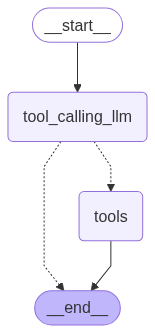

================================ Human Message =================================

1706.03762


In [ ]:
# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))



In [62]:
message=graph.invoke({"messages":HumanMessage(content="provide me the info about bilal siddique")})
for m in message['messages']:
    m.pretty_print()

================================ Human Message =================================

provide me the info about bilal siddique
